In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## Dataset 1 - UrbanSound8K

## Q1)

In [3]:
data = pd.read_csv("/kaggle/input/urbansound8k/UrbanSound8K.csv")
data

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
audio_base_path = "/kaggle/input/urbansound8k"
metadata_path 

In [ ]:
= os.path.join(audio_base_path, "UrbanSound8K.csv")

# Read metadata
df = pd.read_csv(metadata_path)
print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df['class'].value_counts())

# Prepare dataset
features_df = prepare_dataset(df, audio_base_path)
print("\nExtracted features shape:", features_df.shape)

## Analyse MFCC correlations

We transform the frequency scale to the mel scale, which better matches human hearing. For example, while we can easily hear the difference between 100 Hz and 200 Hz, the difference between 10,000 Hz and 10,100 Hz sounds almost the same to us. The mel scale accounts for this by spacing frequency bands more closely in the lower frequencies and more widely in the higher frequencies.

### Steps:
1. First, we divide the audio signal into short frames (typically 20-40ms). This is because audio signals change over time
2. Next, we apply a Fourier transform to each frame to convert it from the time domain to the frequency domain.
3. We convert the frequency scale to the Mel scale.
4. We take the logarithm of these Mel-scale energies because human perception of loudness is also logarithmic. 
5. Finally, we apply a discrete cosine transform (DCT). This helps separate the different components of the sound

### Filter banks
Consists of triangular overlapping filters, More filters in lower frequencies, fewer in higher frequencies, Typically use 20-40 filters

### Last step, DCT (discrete cosine transform) 

In [32]:
def analyze_mfcc_correlations(features_df):
    """
    Create specific visualizations for MFCC features
    """
    # Select only MFCC features
    mfcc_features = [col for col in features_df.columns if 'mfcc' in col]
    mfcc_df = features_df[mfcc_features]
    
    # Create correlation matrix for MFCCs
    plt.figure(figsize=(15, 12))
    mfcc_corr = mfcc_df.corr()
    sns.heatmap(mfcc_corr, 
                cmap='coolwarm', 
                center=0,
                annot=True,
                fmt='.2f')
    plt.title('MFCC Features Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Separate mean and std MFCC features
    mfcc_mean = [col for col in mfcc_features if 'mean' in col]
    mfcc_std = [col for col in mfcc_features if 'std' in col]
    
    # Plot mean MFCC correlations
    plt.figure(figsize=(12, 10))
    mfcc_mean_corr = features_df[mfcc_mean].corr()
    sns.heatmap(mfcc_mean_corr, 
                cmap='coolwarm', 
                center=0,
                annot=True,
                fmt='.2f')
    plt.title('MFCC Mean Features Correlation')
    plt.tight_layout()
    plt.show()
    
    # Plot std MFCC correlations
    plt.figure(figsize=(12, 10))
    mfcc_std_corr = features_df[mfcc_std].corr()
    sns.heatmap(mfcc_std_corr, 
                cmap='coolwarm', 
                center=0,
                annot=True,
                fmt='.2f')
    plt.title('MFCC Std Features Correlation')
    plt.tight_layout()
    plt.show()

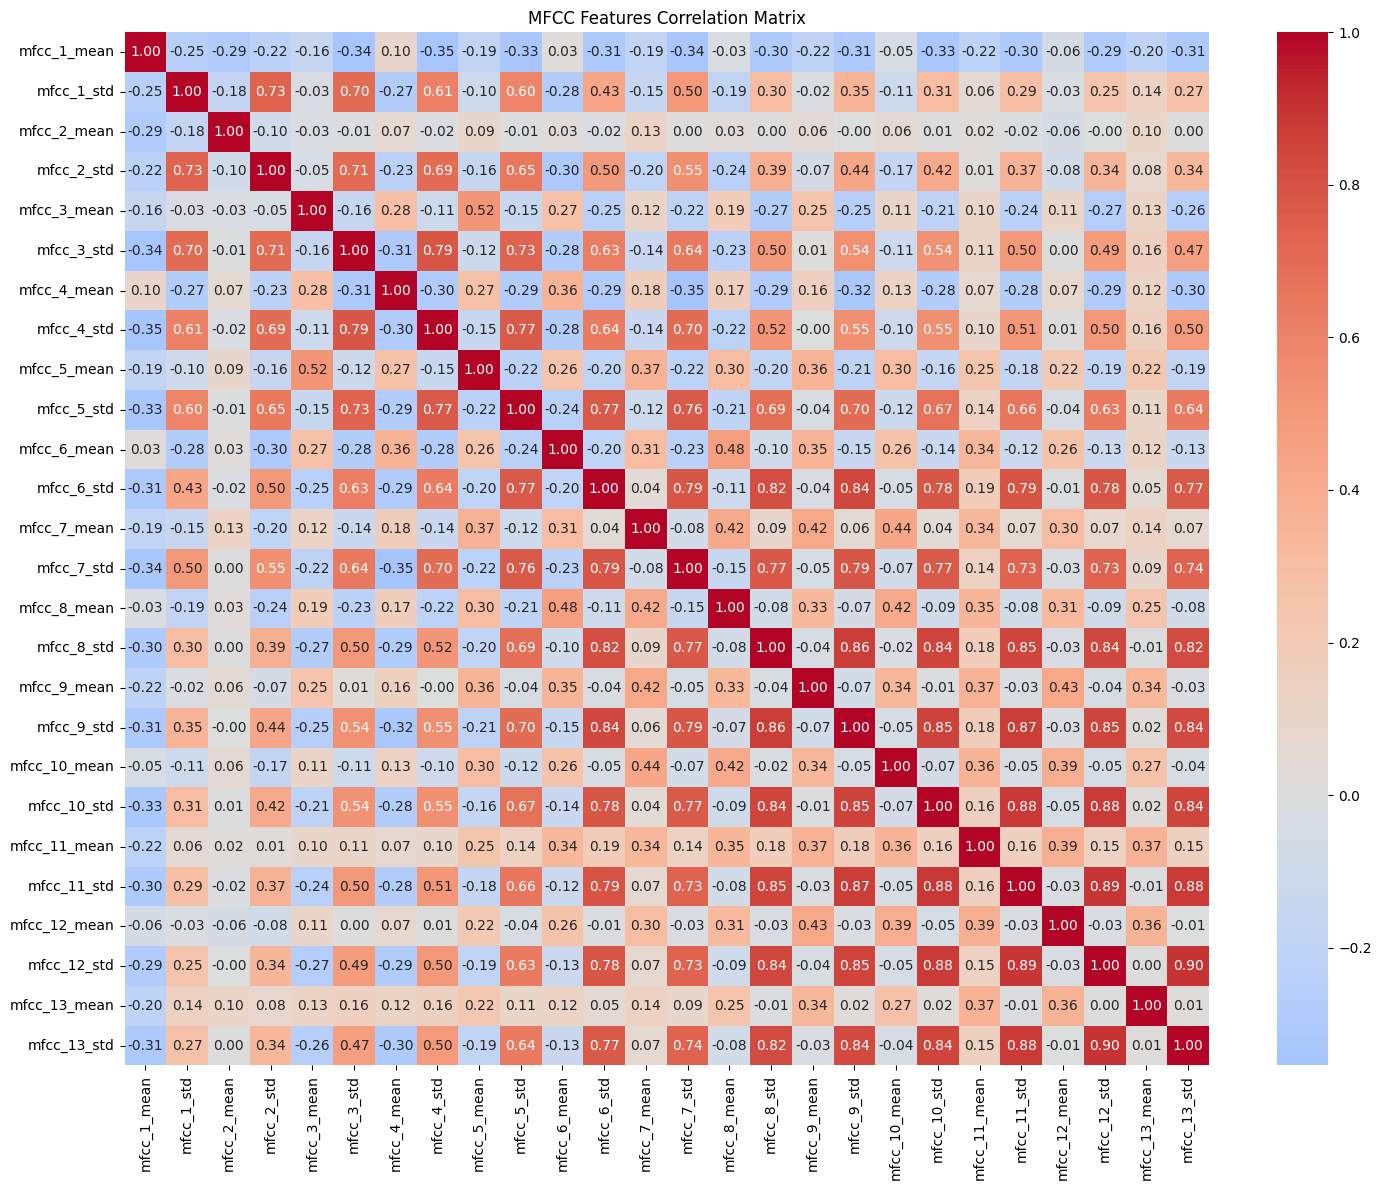

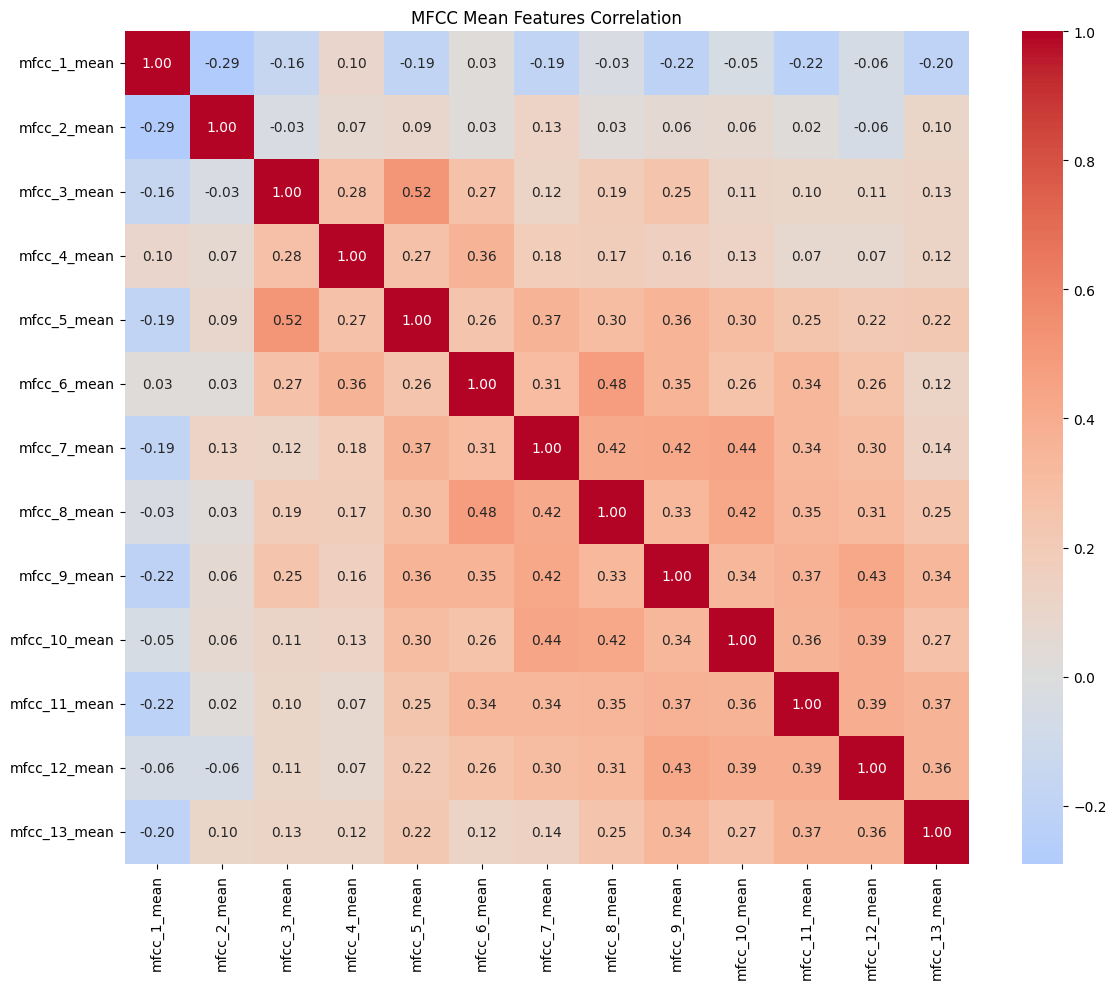

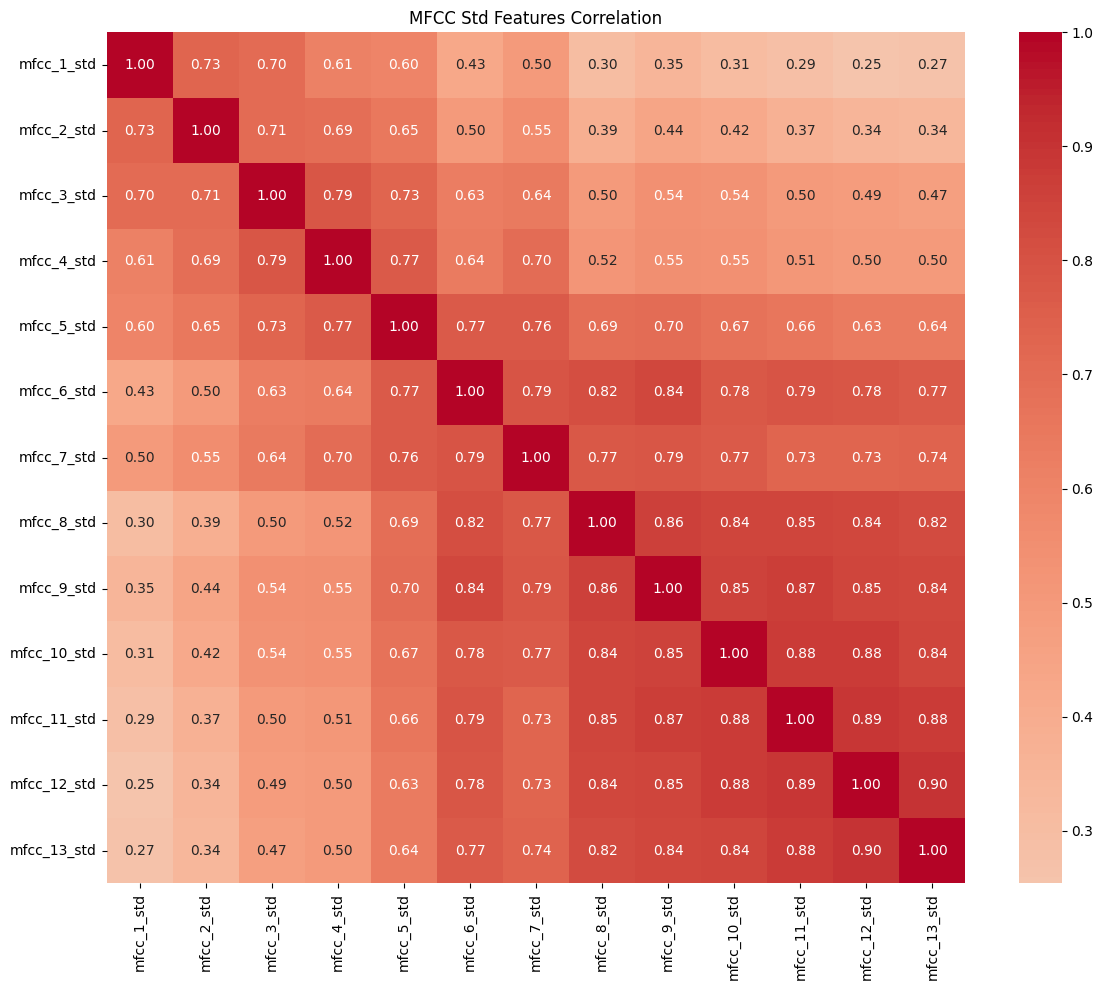

In [33]:
analyze_mfcc_correlations(features_df)

## Model 1: Random forest (Machine learning model)

In [28]:
def extract_features(audio_path):
    """
    Extract audio features from a file
    
    Returns:
        dict: Dictionary containing extracted features
    """
    try:
        # Load the audio file
        y, sr = librosa.load(audio_path, duration=4)
        
        # Initialize dictionary to store features
        features = {}
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        for i, mfcc in enumerate(mfccs):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfcc)
            features[f'mfcc_{i+1}_std'] = np.std(mfcc)
        
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)
        
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)
        
        zero_crossing = librosa.feature.zero_crossing_rate(y)[0]
        features['zero_crossing_rate_mean'] = np.mean(zero_crossing)
        features['zero_crossing_rate_std'] = np.std(zero_crossing)
        
        chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_stft_mean'] = np.mean(chromagram)
        features['chroma_stft_std'] = np.std(chromagram)
        
        rms = librosa.feature.rms(y=y)[0]
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)
        
        return features
    
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {str(e)}")
        return None


In [27]:
def prepare_dataset(df, audio_base_path):
    """
    Prepare dataset by extracting features from all audio files
    """
    # Initialize list to store all features
    all_features = []
    
    # Process each file
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        # Construct full audio path
        audio_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
        
        # Extract features
        features = extract_features(audio_path)
        
        if features is not None:
            # Add class label
            features['class'] = row['class']
            features['classID'] = row['classID']
            all_features.append(features)
    
    # Convert to DataFrame
    features_df = pd.DataFrame(all_features)
    
    return features_df

In [26]:
def train_random_forest(features_df, n_estimators=100):
    """
    Train a Random Forest classifier
    """
    # Separate features and target
    X = features_df.drop(['class', 'classID'], axis=1)
    y = features_df['classID']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test_scaled)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    return rf, scaler


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       203
           1       0.93      0.76      0.83        86
           2       0.80      0.86      0.83       183
           3       0.94      0.89      0.91       201
           4       0.88      0.89      0.89       206
           5       0.91      0.96      0.93       193
           6       0.88      0.92      0.90        72
           7       0.89      0.93      0.91       208
           8       0.92      0.95      0.94       165
           9       0.88      0.85      0.86       230

    accuracy                           0.89      1747
   macro avg       0.90      0.89      0.89      1747
weighted avg       0.90      0.89      0.89      1747



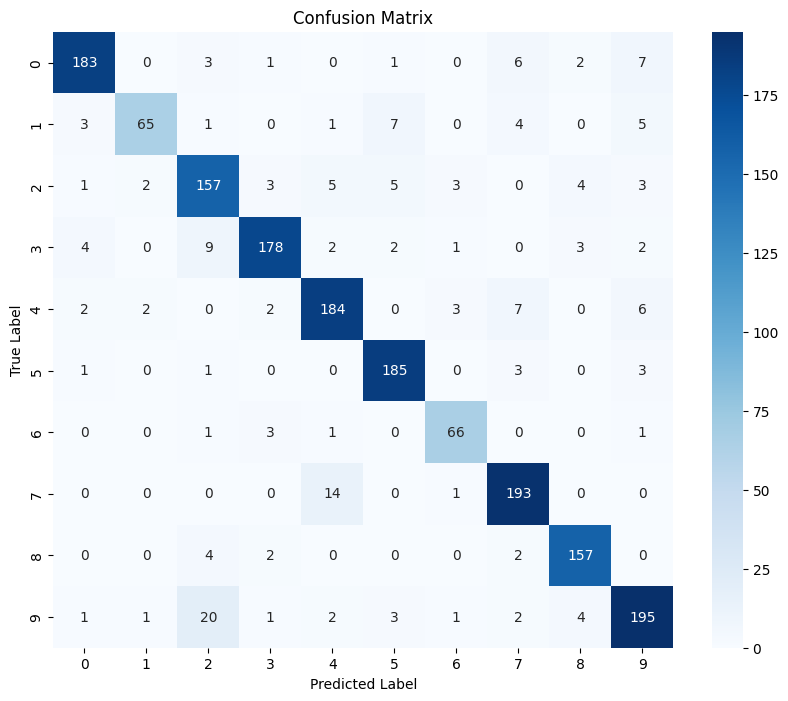

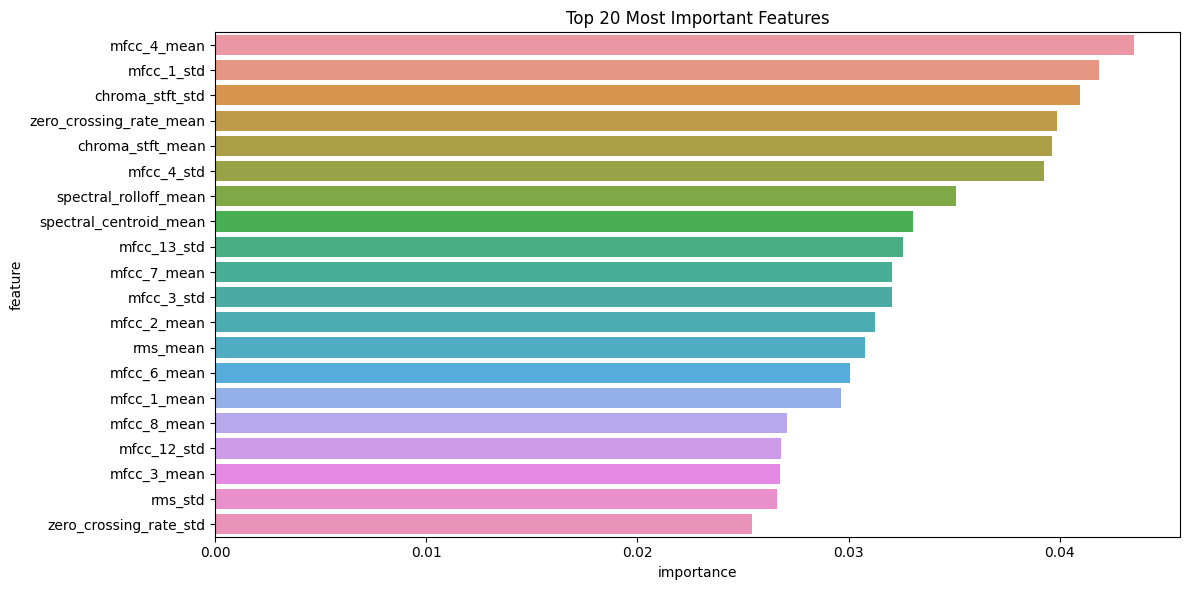

In [31]:
# Train model
rf_model, scaler = train_random_forest(features_df)

#### Overall accuracy of 89%

## Q2)

## Audio processing

In [3]:
class UrbanSoundDataset(Dataset):
    def __init__(self, csv_path, data_path, fold_number, transform=None):
        self.data_path = data_path
        self.transform = transform
        
        # Read CSV file
        self.data = pd.read_csv(csv_path)
        
        if fold_number is not None:
            self.data = self.data[self.data['fold'] == fold_number]
        
        # Fixed length for all audio files (in samples)
        self.fixed_length = 4 * 22050  # 4 seconds at 22050 Hz
        # Fixed size for spectrograms
        self.fixed_specs = (128, 128)  # Mel bins x Time frames
        
    def __len__(self):
        return len(self.data)
    
    def _process_audio(self, audio):
        """Pad or truncate audio to fixed length"""
        if len(audio) > self.fixed_length:
            # Truncate
            audio = audio[:self.fixed_length]
        elif len(audio) < self.fixed_length:
            # Pad with zeros
            padding = self.fixed_length - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        return audio
    
    def _process_spectrogram(self, spec):
        """Resize spectrogram to fixed size using interpolation"""
        if spec.shape[1] > self.fixed_specs[1]:
            # Truncate time axis
            spec = spec[:, :self.fixed_specs[1]]
        elif spec.shape[1] < self.fixed_specs[1]:
            # Pad with zeros
            padding = self.fixed_specs[1] - spec.shape[1]
            spec = np.pad(spec, ((0, 0), (0, padding)), mode='constant')
        return spec
    
    def __getitem__(self, idx):
        try:
            audio_file = os.path.join(self.data_path, 
                                    f"fold{self.data.iloc[idx]['fold']}", 
                                    self.data.iloc[idx]['slice_file_name'])
            
            # Load and process audio
            audio, sr = librosa.load(audio_file, sr=22050)
            audio = self._process_audio(audio)
            
            mel_spec = librosa.feature.melspectrogram(y=audio, 
                                                    sr=sr,
                                                    n_mels=self.fixed_specs[0],
                                                    hop_length=512)
            
            # Convert to log scale
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # Process spectrogram to fixed size
            mel_spec_db = self._process_spectrogram(mel_spec_db)
            
            # Normalize
            mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
            
            # Convert to tensor
            feature = torch.FloatTensor(mel_spec_db)
            label = torch.tensor(self.data.iloc[idx]['classID'])
            
            return feature, label
            
        except Exception as e:
            print(f"Error processing file {audio_file}: {str(e)}")
            # Return a zero tensor of the correct shape and the label
            return torch.zeros(self.fixed_specs), torch.tensor(self.data.iloc[idx]['classID'])

In [23]:
def get_data_loaders(csv_path, data_path, fold, batch_size=32):
    """
    Create train and test data loaders for a specific fold
    """
    # Create datasets for train and test
    train_dataset = UrbanSoundDataset(csv_path, data_path, fold)
    test_dataset = UrbanSoundDataset(csv_path, data_path, fold)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return train_loader, test_loader

In [4]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
    def forward(self, x):
    # Add channel dimension
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=128, hidden_size=256, num_layers=2, num_classes=10):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # all parameters updated
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


In [7]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc

In [8]:
def plot_audio_features(audio_path):
    # Load audio
    audio, sr = librosa.load(audio_path, duration=4)
    
    plt.figure(figsize=(15, 10))
    
    # Plot waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    
    # Plot spectrogram
    plt.subplot(3, 1, 2)
    spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    
    # Plot MFCC
    plt.subplot(3, 1, 3)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    
    plt.tight_layout()
    plt.show()

## Q2) and Q3) graphs

Audio file: 1


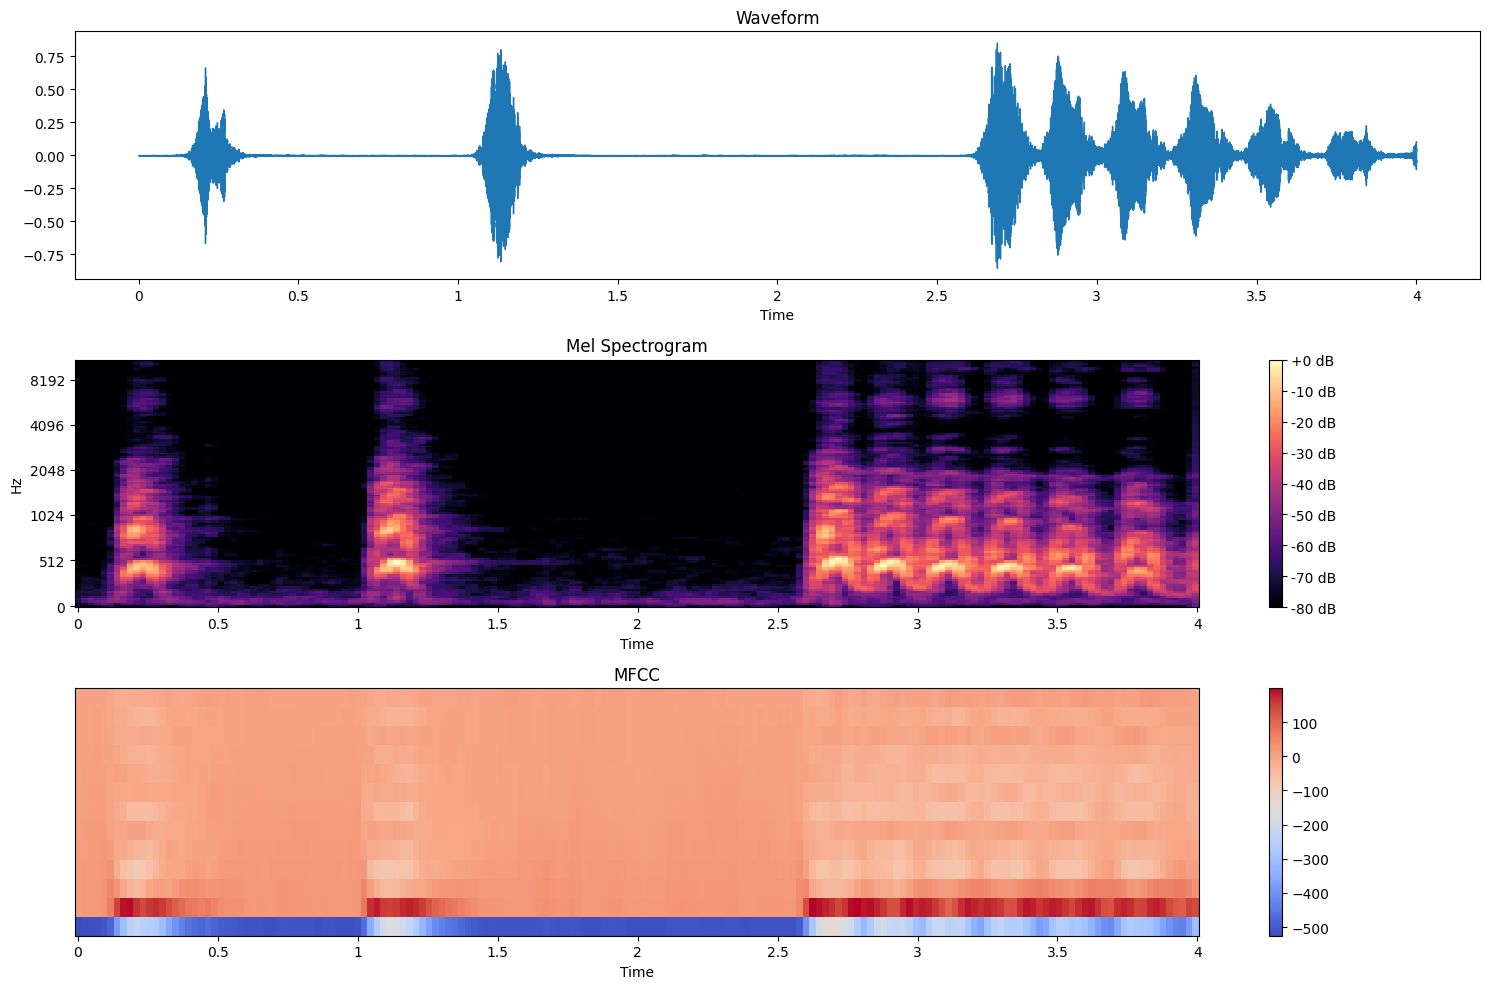

Audio file: 2


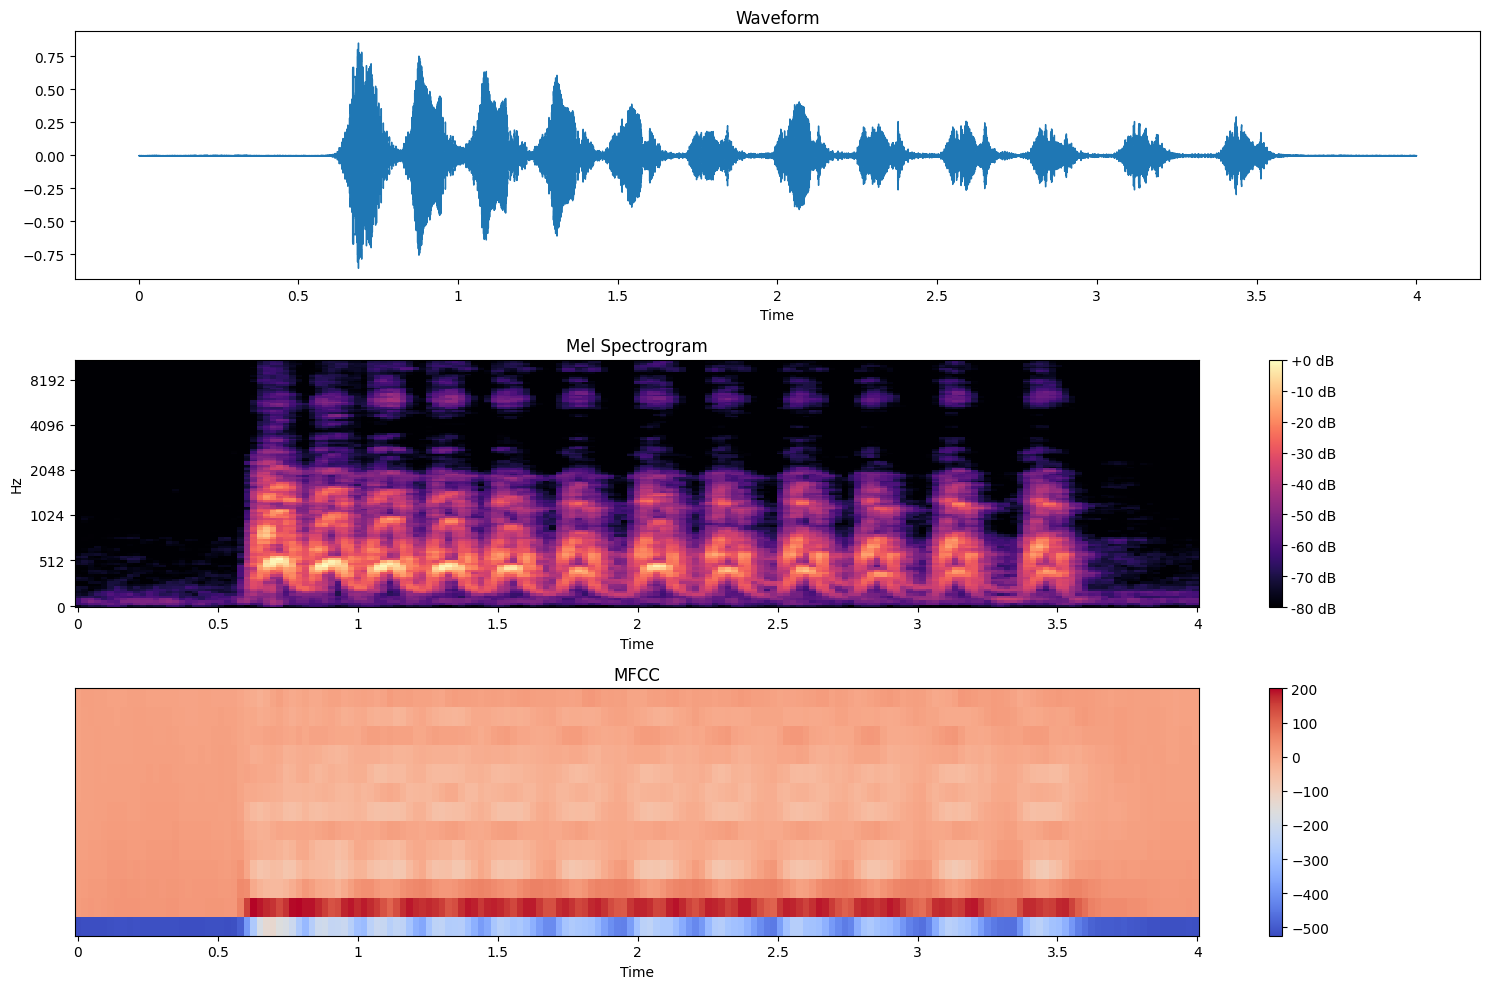

Audio file: 3


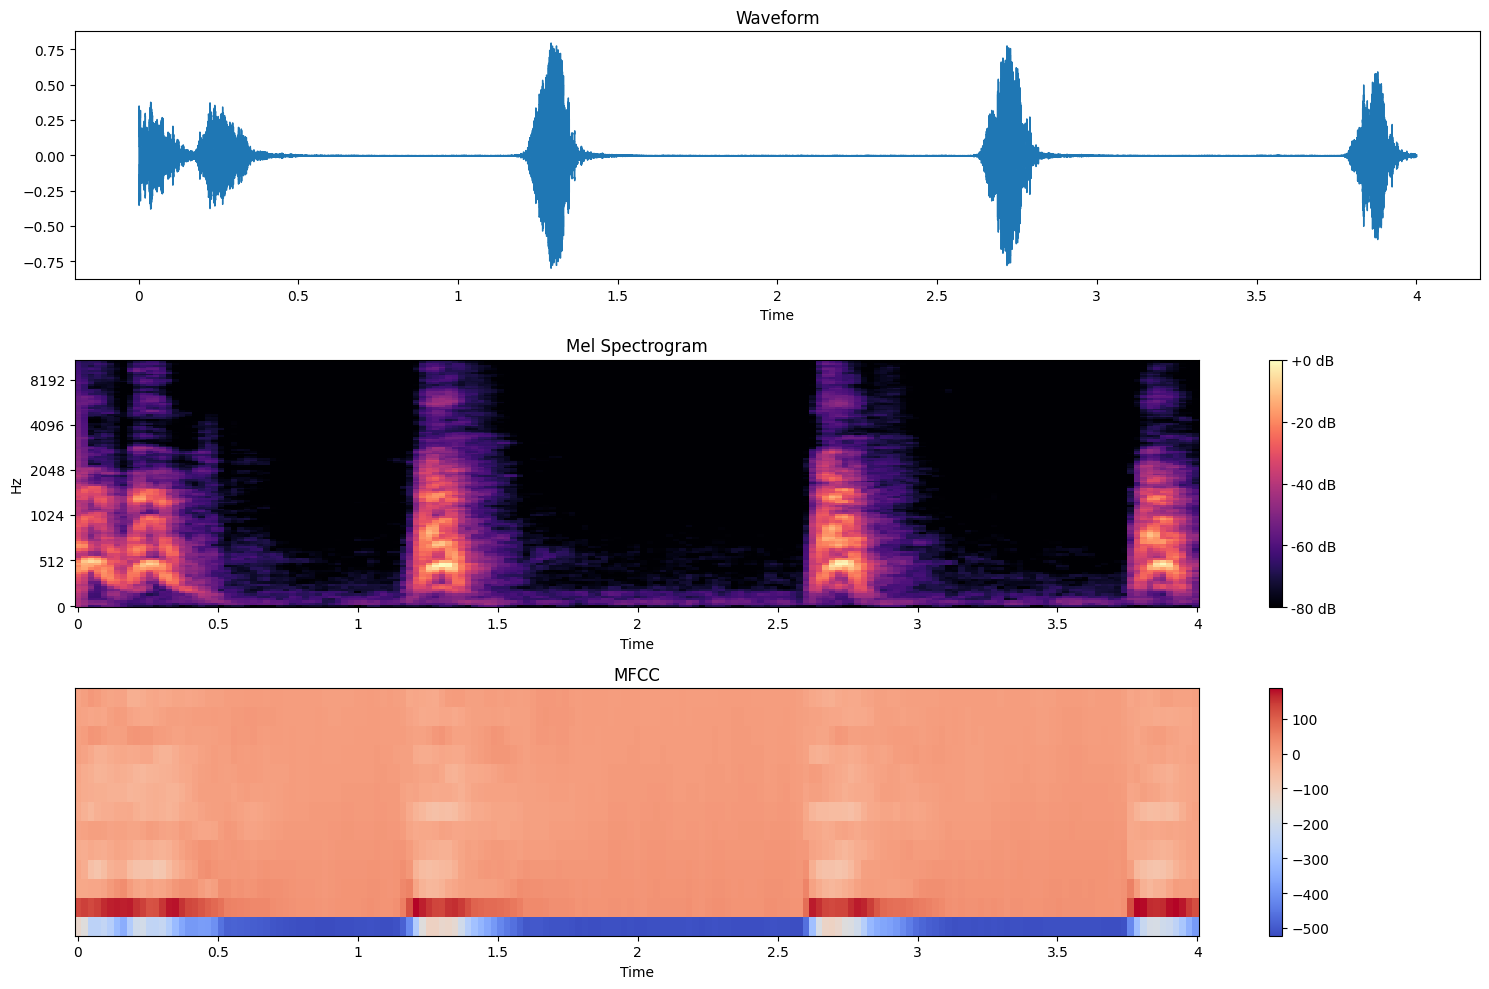

Audio file: 4


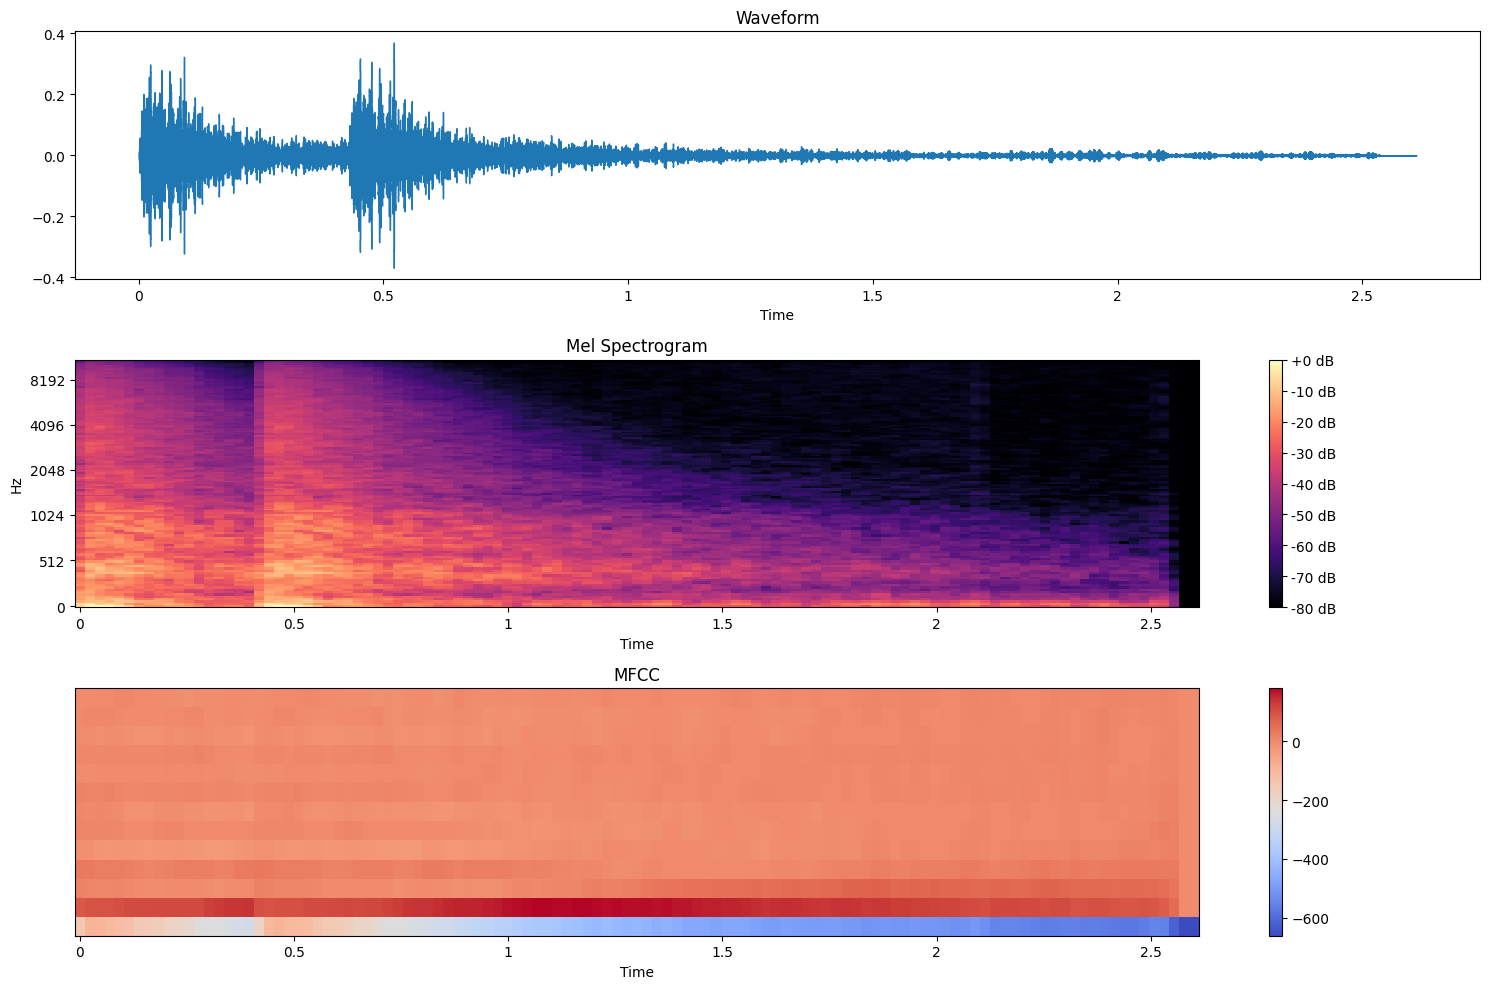

In [21]:
list_aud = ["/kaggle/input/urbansound8k/fold1/101415-3-0-2.wav", "/kaggle/input/urbansound8k/fold1/101415-3-0-3.wav", "/kaggle/input/urbansound8k/fold1/101415-3-0-8.wav", "/kaggle/input/urbansound8k/fold1/102305-6-0-0.wav"]
i = 1
for audio_fil in list_aud:
    print(f"Audio file: {i}")
    plot_audio_features(audio_fil)
    i += 1

In [37]:
import IPython.display as ipd
for audio_fil in list_aud:
    print(f"Audio file: {i}")
    audio, sr = librosa.load(audio_fil, duration=4, sr=22050)
    ipd.Audio(audio, rate=sr)
    i += 1

Audio file: 5
Audio file: 6
Audio file: 7
Audio file: 8


### Observations:
1. There are several distinct audio events/bursts.
2. The waveforms clearly show the quite periods in between
3. The Mel Spectrogram shows the frequency content over time using a mel scale (which better represents human hearing).
4. Bright orange/red areas indicate strong frequency components
5. Strong energy concentration in the lower frequencies (below 1024 Hz)
6. The MFCC plot shows the Mel-frequency cepstral coefficients
7. Represents the spectral envelope of the sound
8. The red and blue regions indicate positive and negative coefficients respectively
9. There's a strong contrast between the coefficients, particularly in the lower bands

## Q4)

In [13]:
torch.cuda.is_available()

True

## Model 2: CNN

Using device: cuda

Fold 1/10
features:  tensor([[-0.2102, -0.3661, -0.4446,  ...,  0.1465, -0.1734, -0.1373],
        [-0.3904, -0.0978,  0.2821,  ...,  0.5689,  0.5772,  0.4241],
        [ 0.1330,  0.7294,  1.0157,  ...,  1.0139,  0.6549,  1.0311],
        ...,
        [-0.5688, -0.5688, -0.5688,  ..., -0.0461,  0.1725,  0.2524],
        [-0.5688, -0.5688, -0.5688,  ...,  0.0447, -0.0081,  0.0111],
        [-0.5688, -0.5688, -0.5688,  ..., -0.4771, -0.5688, -0.5688]])
lable:  tensor(3)

Training CNN


100%|██████████| 28/28 [00:15<00:00,  1.79it/s]


train loss: 1.881733809198652, test loss: 1.2665745610637325
train accuracy: 30.584192439862544, test accuracy: 68.27033218785796


100%|██████████| 28/28 [00:15<00:00,  1.85it/s]


train loss: 1.0987838123525893, test loss: 0.8203937978084598
train accuracy: 62.31386025200458, test accuracy: 73.65406643757159


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


train loss: 0.635585082428796, test loss: 0.5935734345444611
train accuracy: 80.64146620847652, test accuracy: 80.98510882016036


100%|██████████| 28/28 [00:15<00:00,  1.81it/s]


train loss: 0.49818274272339685, test loss: 0.30277926445705816
train accuracy: 83.8487972508591, test accuracy: 91.06529209621993


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


train loss: 0.3082769497996196, test loss: 0.19094139128927573
train accuracy: 90.03436426116839, test accuracy: 95.07445589919817


100%|██████████| 28/28 [00:15<00:00,  1.83it/s]


train loss: 0.208349510827767, test loss: 0.16068588516022178
train accuracy: 92.78350515463917, test accuracy: 95.30355097365407


100%|██████████| 28/28 [00:15<00:00,  1.83it/s]


train loss: 0.12231054529547691, test loss: 0.07311188856043113
train accuracy: 96.33447880870561, test accuracy: 98.28178694158076


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


train loss: 0.06552135768080396, test loss: 0.05368997983090854
train accuracy: 97.9381443298969, test accuracy: 98.16723940435281


100%|██████████| 28/28 [00:15<00:00,  1.84it/s]


train loss: 0.05760261100450797, test loss: 0.025701616496917268
train accuracy: 98.39633447880871, test accuracy: 99.7709049255441


100%|██████████| 28/28 [00:15<00:00,  1.85it/s]


train loss: 0.1478420410837446, test loss: 0.08043655782863166
train accuracy: 95.76174112256587, test accuracy: 97.709049255441

Fold 2/10
features:  tensor([[-1.3057,  0.2607,  0.7280,  ...,  1.4214,  1.2207,  0.4907],
        [-1.4854,  0.1376,  0.6880,  ...,  1.3070,  1.1203,  0.3705],
        [-1.8743, -0.5646, -0.1116,  ...,  0.7494,  0.5896, -0.0042],
        ...,
        [-1.8743, -1.8743, -1.5378,  ..., -1.8743, -1.8743, -1.8743],
        [-1.8743, -1.8743, -1.6111,  ..., -1.8743, -1.8743, -1.8743],
        [-1.8743, -1.8743, -1.8743,  ..., -1.8743, -1.8743, -1.8743]])
lable:  tensor(3)

Training CNN


100%|██████████| 28/28 [00:15<00:00,  1.86it/s]


train loss: 1.0981561211603028, test loss: 0.46803657876859817
train accuracy: 64.1891891891892, test accuracy: 85.58558558558559


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


train loss: 0.4662702807358333, test loss: 0.27250451237029794
train accuracy: 84.90990990990991, test accuracy: 92.22972972972973


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


train loss: 0.21452153686966216, test loss: 0.13477003702012422
train accuracy: 92.9054054054054, test accuracy: 95.72072072072072


100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


train loss: 0.11587286441187773, test loss: 0.05442002870144539
train accuracy: 96.73423423423424, test accuracy: 98.64864864864865


100%|██████████| 28/28 [00:14<00:00,  1.92it/s]


train loss: 0.05991059169173241, test loss: 0.0683767013025707
train accuracy: 98.3108108108108, test accuracy: 97.52252252252252


100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


train loss: 0.09510606567242316, test loss: 0.09368680669285823
train accuracy: 96.509009009009, test accuracy: 96.73423423423424


100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


train loss: 0.09817062883770891, test loss: 0.052917218452421366
train accuracy: 96.3963963963964, test accuracy: 98.53603603603604


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


train loss: 0.048371601034887135, test loss: 0.03276220840318648
train accuracy: 98.87387387387388, test accuracy: 99.32432432432432


100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


train loss: 0.021611130282898166, test loss: 0.006590151672883492
train accuracy: 99.54954954954955, test accuracy: 99.88738738738739


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


train loss: 0.027264036656041362, test loss: 0.18396581563527953
train accuracy: 99.32432432432432, test accuracy: 93.91891891891892

Fold 3/10
features:  tensor([[ 2.2624e-03,  3.0748e-01,  2.8058e-01,  ...,  6.4286e-01,
          5.8148e-01,  4.4375e-01],
        [ 5.7043e-01,  7.0924e-01,  3.0670e-01,  ...,  5.1727e-01,
          6.6707e-01,  3.7301e-01],
        [ 7.0171e-01,  5.6993e-01,  1.6698e-01,  ...,  3.0146e-01,
          5.4904e-01,  6.2665e-01],
        ...,
        [-1.6103e+00, -1.3379e+00, -1.5163e+00,  ..., -1.5453e+00,
         -1.0470e+00, -1.0967e+00],
        [-1.8803e+00, -1.6269e+00, -1.7252e+00,  ..., -1.8446e+00,
         -1.2186e+00, -1.2747e+00],
        [-2.5032e+00, -2.4650e+00, -2.5879e+00,  ..., -3.4472e+00,
         -2.7731e+00, -2.7511e+00]])
lable:  tensor(3)

Training CNN


100%|██████████| 29/29 [00:15<00:00,  1.87it/s]


train loss: 1.2704989468229229, test loss: 0.4916452518824873
train accuracy: 70.91891891891892, test accuracy: 83.67567567567568


100%|██████████| 29/29 [00:15<00:00,  1.92it/s]


train loss: 0.3450644190969138, test loss: 0.20386775236994284
train accuracy: 89.62162162162163, test accuracy: 94.27027027027027


100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


train loss: 0.1983002013815888, test loss: 0.16713132084435622
train accuracy: 94.27027027027027, test accuracy: 95.13513513513513


100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


train loss: 0.1186491384588439, test loss: 0.056443439332912834
train accuracy: 96.32432432432432, test accuracy: 99.45945945945945


100%|██████████| 29/29 [00:14<00:00,  1.97it/s]


train loss: 0.05482955734598739, test loss: 0.021683155588608973
train accuracy: 98.37837837837837, test accuracy: 99.89189189189189


100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


train loss: 0.020774461272782808, test loss: 0.012497391756463411
train accuracy: 99.78378378378379, test accuracy: 100.0


100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


train loss: 0.0089847802682298, test loss: 0.005811567667855155
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 29/29 [00:14<00:00,  1.96it/s]


train loss: 0.005878899956989135, test loss: 0.0027870842528061293
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 29/29 [00:14<00:00,  2.01it/s]


train loss: 0.002964790499014459, test loss: 0.0017850627585897295
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


train loss: 0.0016040973639284294, test loss: 0.0012307557539284531
train accuracy: 100.0, test accuracy: 100.0

Fold 4/10
features:  tensor([[ 0.3587,  0.8431,  0.9122,  ...,  0.5941,  0.6360,  0.6117],
        [-0.0789,  0.2798,  0.5867,  ...,  0.6902,  0.4810,  0.3583],
        [-0.3227,  0.3628,  0.6145,  ...,  0.7443,  0.5184,  0.7118],
        ...,
        [-1.6186, -1.2573, -0.7738,  ..., -1.5949, -1.6952, -2.1786],
        [-2.0493, -1.6347, -1.1935,  ..., -2.1559, -2.2381, -2.6752],
        [-3.4650, -2.5951, -2.3534,  ..., -2.7146, -2.7945, -3.5149]])
lable:  tensor(3)

Training CNN


100%|██████████| 31/31 [00:17<00:00,  1.81it/s]


train loss: 1.5114280062337075, test loss: 0.5005637183785439
train accuracy: 66.46464646464646, test accuracy: 86.56565656565657


100%|██████████| 31/31 [00:16<00:00,  1.86it/s]


train loss: 0.38251650766018896, test loss: 0.25998793845816004
train accuracy: 88.58585858585859, test accuracy: 92.42424242424242


100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


train loss: 0.21584024556702183, test loss: 0.1091680009210963
train accuracy: 93.13131313131314, test accuracy: 97.87878787878788


100%|██████████| 31/31 [00:16<00:00,  1.91it/s]


train loss: 0.08775537052462178, test loss: 0.039540001221710905
train accuracy: 97.17171717171718, test accuracy: 99.1919191919192


100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


train loss: 0.040072884500747724, test loss: 0.013992394949685062
train accuracy: 99.0909090909091, test accuracy: 99.8989898989899


100%|██████████| 31/31 [00:16<00:00,  1.85it/s]


train loss: 0.013452616279884692, test loss: 0.006113401629737646
train accuracy: 99.79797979797979, test accuracy: 100.0


100%|██████████| 31/31 [00:16<00:00,  1.88it/s]


train loss: 0.006639097167569543, test loss: 0.0030699049006685645
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 31/31 [00:16<00:00,  1.86it/s]


train loss: 0.0030125087059493507, test loss: 0.002207289820709716
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 31/31 [00:16<00:00,  1.87it/s]


train loss: 0.0018987468586513592, test loss: 0.0013390981947292945
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 31/31 [00:16<00:00,  1.87it/s]


train loss: 0.0012993716415122993, test loss: 0.0010834921354657009
train accuracy: 100.0, test accuracy: 100.0

Fold 5/10
features:  tensor([[ 0.2501,  0.7269,  0.7844,  ..., -0.3157, -0.3157, -0.3157],
        [ 0.4187,  0.7988,  0.9490,  ..., -0.3157, -0.3157, -0.3157],
        [ 0.6845,  1.0320,  1.0347,  ..., -0.3157, -0.3157, -0.3157],
        ...,
        [ 0.2363,  1.6085,  2.4335,  ..., -0.3157, -0.3157, -0.3157],
        [ 0.1525,  1.5506,  2.1223,  ..., -0.3157, -0.3157, -0.3157],
        [-0.3157,  0.5940,  1.1925,  ..., -0.3157, -0.3157, -0.3157]])
lable:  tensor(3)

Training CNN


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


train loss: 0.9694725508491199, test loss: 0.38717545898010336
train accuracy: 77.56410256410257, test accuracy: 88.24786324786325


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


train loss: 0.2553603060543537, test loss: 0.23725642501134037
train accuracy: 91.66666666666667, test accuracy: 93.58974358974359


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


train loss: 0.16756645403802395, test loss: 0.1060825303706224
train accuracy: 95.08547008547009, test accuracy: 97.00854700854701


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


train loss: 0.14898598128929735, test loss: 0.04483084659247349
train accuracy: 95.83333333333333, test accuracy: 99.46581196581197


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


train loss: 0.07641387710658212, test loss: 0.027903954319966336
train accuracy: 97.75641025641026, test accuracy: 99.57264957264957


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


train loss: 0.02292814451890687, test loss: 0.013055576552778803
train accuracy: 99.67948717948718, test accuracy: 100.0


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


train loss: 0.010009449834857758, test loss: 0.0038737296165739584
train accuracy: 99.78632478632478, test accuracy: 100.0


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


train loss: 0.0038854668227334818, test loss: 0.0019352942949656911
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 30/30 [00:15<00:00,  1.96it/s]


train loss: 0.0019633717466300974, test loss: 0.0013875136563001433
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 30/30 [00:15<00:00,  1.94it/s]


train loss: 0.0011669445142615587, test loss: 0.0010064933143439704
train accuracy: 100.0, test accuracy: 100.0

Fold 6/10
features:  tensor([[-3.8652, -2.9923, -1.8279,  ..., -0.2917, -0.2666,  0.1526],
        [-3.8652, -2.6689, -1.6581,  ...,  0.2080, -0.1694,  0.1276],
        [-3.8652, -2.7938, -2.0890,  ..., -0.3432, -0.3077, -0.2914],
        ...,
        [-3.8652, -3.6046, -2.9901,  ..., -0.5149, -0.4164, -0.3315],
        [-3.8652, -3.7742, -3.2975,  ..., -1.0577, -0.7147, -0.5167],
        [-3.8652, -3.8652, -3.8652,  ..., -1.7871, -1.6704, -1.7554]])
lable:  tensor(3)

Training CNN


100%|██████████| 26/26 [00:13<00:00,  1.96it/s]


train loss: 1.0240843823322883, test loss: 0.3567751312198547
train accuracy: 75.94167679222357, test accuracy: 89.55042527339003


100%|██████████| 26/26 [00:13<00:00,  1.96it/s]


train loss: 0.27197474241256714, test loss: 0.15577471791766584
train accuracy: 90.88699878493317, test accuracy: 95.50425273390036


100%|██████████| 26/26 [00:12<00:00,  2.00it/s]


train loss: 0.13189311501068565, test loss: 0.06524415228229302
train accuracy: 95.62575941676792, test accuracy: 98.42041312272175


100%|██████████| 26/26 [00:12<00:00,  2.02it/s]


train loss: 0.05934024541280591, test loss: 0.02772334902189099
train accuracy: 98.29890643985419, test accuracy: 99.27095990279466


100%|██████████| 26/26 [00:12<00:00,  2.04it/s]


train loss: 0.021459291411492113, test loss: 0.009914668876892673
train accuracy: 99.63547995139733, test accuracy: 100.0


100%|██████████| 26/26 [00:12<00:00,  2.02it/s]


train loss: 0.009753287796719143, test loss: 0.0045723965348980315
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.99it/s]


train loss: 0.003925930321341953, test loss: 0.0026746315259235697
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


train loss: 0.0022269840416041776, test loss: 0.0015597198552523667
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 26/26 [00:12<00:00,  2.01it/s]


train loss: 0.0015309252149353807, test loss: 0.0011304915359897467
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 26/26 [00:12<00:00,  2.07it/s]


train loss: 0.001099156501228348, test loss: 0.0008518860237158011
train accuracy: 100.0, test accuracy: 100.0

Fold 7/10
features:  tensor([[ 0.5852,  0.6904,  0.5292,  ...,  0.8412,  0.7991,  0.7074],
        [ 0.5429,  0.9258,  0.7824,  ...,  2.0057,  1.9746,  1.7603],
        [ 1.1738,  1.3166,  1.2519,  ...,  1.8954,  1.8110,  1.5960],
        ...,
        [-1.2944, -1.0265, -1.0350,  ..., -1.6985, -1.4635, -1.0679],
        [-1.5049, -1.2360, -0.9667,  ..., -1.6383, -1.5011, -1.1309],
        [-1.8602, -1.6493, -1.5064,  ..., -2.4215, -2.3971, -2.1141]])
lable:  tensor(9)

Training CNN


100%|██████████| 27/27 [00:14<00:00,  1.92it/s]


train loss: 1.1036715187408306, test loss: 0.276677419466001
train accuracy: 74.82100238663485, test accuracy: 93.19809069212411


100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


train loss: 0.23047816049721506, test loss: 0.12247721050624494
train accuracy: 93.79474940334129, test accuracy: 96.53937947494033


100%|██████████| 27/27 [00:13<00:00,  1.93it/s]


train loss: 0.10447797317195821, test loss: 0.05566742907588681
train accuracy: 97.37470167064438, test accuracy: 99.0453460620525


100%|██████████| 27/27 [00:14<00:00,  1.88it/s]


train loss: 0.03984991527869607, test loss: 0.019978524151223677
train accuracy: 99.40334128878281, test accuracy: 99.88066825775657


100%|██████████| 27/27 [00:14<00:00,  1.92it/s]


train loss: 0.018307079362717492, test loss: 0.014485874814757457
train accuracy: 99.88066825775657, test accuracy: 99.88066825775657


100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


train loss: 0.033599471768226336, test loss: 0.009624323949942159
train accuracy: 99.0453460620525, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


train loss: 0.0072766931117695536, test loss: 0.0034101001004240026
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


train loss: 0.002576519648923918, test loss: 0.0015723923872293973
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


train loss: 0.0013701175312571987, test loss: 0.001083765016152972
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


train loss: 0.0010441691141480718, test loss: 0.0008116870869546094
train accuracy: 100.0, test accuracy: 100.0

Fold 8/10
features:  tensor([[-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        ...,
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281]])
lable:  tensor(3)

Training CNN


100%|██████████| 26/26 [00:13<00:00,  1.86it/s]


train loss: 1.0790604215401869, test loss: 0.4180480660870671
train accuracy: 74.56575682382135, test accuracy: 89.70223325062035


100%|██████████| 26/26 [00:13<00:00,  1.88it/s]


train loss: 0.27746845412856114, test loss: 0.14076983713424013
train accuracy: 90.1985111662531, test accuracy: 95.6575682382134


100%|██████████| 26/26 [00:13<00:00,  1.88it/s]


train loss: 0.12208687148701686, test loss: 0.07901005878990802
train accuracy: 96.15384615384616, test accuracy: 97.89081885856079


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


train loss: 0.05772804733938896, test loss: 0.02942967730660502
train accuracy: 98.63523573200993, test accuracy: 99.50372208436724


100%|██████████| 26/26 [00:13<00:00,  1.97it/s]


train loss: 0.024439120647282556, test loss: 0.009735308065361235
train accuracy: 99.62779156327544, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


train loss: 0.018282311252103403, test loss: 0.01186160553956702
train accuracy: 99.50372208436724, test accuracy: 99.50372208436724


100%|██████████| 26/26 [00:13<00:00,  1.95it/s]


train loss: 0.008033756493554952, test loss: 0.013549273614234362
train accuracy: 99.87593052109182, test accuracy: 99.62779156327544


100%|██████████| 26/26 [00:13<00:00,  1.89it/s]


train loss: 0.005353245946865242, test loss: 0.001679613319221464
train accuracy: 99.87593052109182, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.92it/s]


train loss: 0.00751755995532641, test loss: 0.004807785006190757
train accuracy: 99.75186104218362, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.96it/s]


train loss: 0.008613374084234238, test loss: 0.0032105337504617637
train accuracy: 99.87593052109182, test accuracy: 100.0

Fold 9/10
features:  tensor([[ 2.7520,  2.5346,  2.4229,  ...,  2.2114,  2.2392,  2.3256],
        [ 2.8419,  3.1037,  2.7449,  ...,  2.0533,  2.1045,  2.6128],
        [ 2.8512,  2.9582,  2.1949,  ...,  3.0839,  3.0495,  2.7515],
        ...,
        [-0.0944,  0.1027, -0.1074,  ..., -1.4198, -1.0802, -1.3007],
        [-0.6129, -0.7457, -0.5936,  ..., -2.0994, -1.7764, -1.7482],
        [-2.5403, -2.6643, -2.4629,  ..., -3.7423, -3.8944, -4.0579]])
lable:  tensor(0)

Training CNN


100%|██████████| 26/26 [00:13<00:00,  1.86it/s]


train loss: 1.126441352069378, test loss: 0.32343589432107717
train accuracy: 77.45098039215686, test accuracy: 89.82843137254902


100%|██████████| 26/26 [00:13<00:00,  1.91it/s]


train loss: 0.22655790886626795, test loss: 0.1018659762556546
train accuracy: 93.13725490196079, test accuracy: 97.30392156862744


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


train loss: 0.08428645879030228, test loss: 0.05633341896613659
train accuracy: 97.91666666666667, test accuracy: 99.01960784313725


100%|██████████| 26/26 [00:13<00:00,  1.88it/s]


train loss: 0.038357208867987186, test loss: 0.01670373113653603
train accuracy: 98.8970588235294, test accuracy: 99.38725490196079


100%|██████████| 26/26 [00:13<00:00,  1.89it/s]


train loss: 0.012269026304308612, test loss: 0.00680226721327087
train accuracy: 99.75490196078431, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.90it/s]


train loss: 0.00964803396177908, test loss: 0.0035474581727601598
train accuracy: 99.87745098039215, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.94it/s]


train loss: 0.004223841358907521, test loss: 0.0017098052300267542
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


train loss: 0.0014697419504115644, test loss: 0.0010351540811272414
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.93it/s]


train loss: 0.0009322040412091435, test loss: 0.0007389510897942623
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 26/26 [00:13<00:00,  1.94it/s]


train loss: 0.0006951890598149755, test loss: 0.0005749465463203216
train accuracy: 100.0, test accuracy: 100.0

Fold 10/10
features:  tensor([[ 0.7884,  1.0869,  1.0219,  ..., -0.5325, -0.5325, -0.5325],
        [ 0.8357,  1.2664,  1.3612,  ..., -0.5325, -0.5325, -0.5325],
        [ 1.2022,  1.7546,  1.8261,  ..., -0.5325, -0.5325, -0.5325],
        ...,
        [ 0.1982,  0.7991,  1.0050,  ..., -0.5325, -0.5325, -0.5325],
        [ 0.0118,  0.6506,  0.9131,  ..., -0.5325, -0.5325, -0.5325],
        [-0.3724,  0.1359,  0.4095,  ..., -0.5325, -0.5325, -0.5325]])
lable:  tensor(1)

Training CNN


100%|██████████| 27/27 [00:14<00:00,  1.86it/s]


train loss: 1.0231201127171516, test loss: 0.3255253435388483
train accuracy: 74.79091995221027, test accuracy: 89.24731182795699


100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


train loss: 0.2629339457662017, test loss: 0.1157341505728524
train accuracy: 90.8004778972521, test accuracy: 97.0131421744325


100%|██████████| 27/27 [00:14<00:00,  1.92it/s]


train loss: 0.11300939356011373, test loss: 0.06115876350210143
train accuracy: 97.0131421744325, test accuracy: 98.5663082437276


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


train loss: 0.06811208619425695, test loss: 0.033311401242153135
train accuracy: 98.3273596176822, test accuracy: 99.6415770609319


100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


train loss: 0.02429940841264195, test loss: 0.008615900124789699
train accuracy: 99.7610513739546, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


train loss: 0.008708132754286958, test loss: 0.004264168396073526
train accuracy: 99.8805256869773, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.98it/s]


train loss: 0.003942337318289059, test loss: 0.0023226845090633746
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


train loss: 0.0019389617028301236, test loss: 0.0012525524127669188
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 27/27 [00:14<00:00,  1.92it/s]


train loss: 0.0011671038077178378, test loss: 0.0008953725555561168
train accuracy: 100.0, test accuracy: 100.0


100%|██████████| 27/27 [00:13<00:00,  1.93it/s]


train loss: 0.000838027335568633, test loss: 0.0006946229134849057
train accuracy: 100.0, test accuracy: 100.0

Final Results:
CNN: 99.97% ± 0.07%


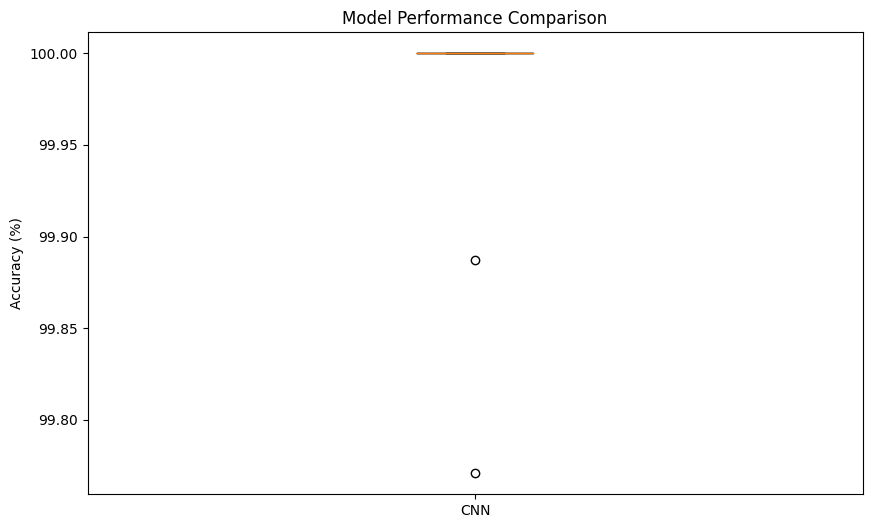

In [35]:
data_path = "/kaggle/input/urbansound8k"
csv_path = os.path.join(data_path, "UrbanSound8K.csv")

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up TensorBoard
writer = SummaryWriter('runs/urbansound_experiment')

# Initialize models
models = {
    'CNN': CNNModel()
}

# Training parameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Results storage
results = {model_name: [] for model_name in models.keys()}

# 10-fold cross validation
for fold in range(1, 11):
    print(f"\nFold {fold}/10")
    
    # Prepare datasets
    train_dataset = UrbanSoundDataset(csv_path, data_path, fold)
    test_dataset = UrbanSoundDataset(csv_path, data_path, fold)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    feature, lable = train_dataset[0]
    print("features: ", feature)
    print("lable: ", lable)
    
    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}")
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        best_acc = 0.0
        for epoch in range(num_epochs):
            train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
            
            # Log to TensorBoard
            writer.add_scalar(f'{model_name}/Fold{fold}/Train_Loss', train_loss, epoch)
            writer.add_scalar(f'{model_name}/Fold{fold}/Train_Acc', train_acc, epoch)
            writer.add_scalar(f'{model_name}/Fold{fold}/Test_Loss', test_loss, epoch)
            writer.add_scalar(f'{model_name}/Fold{fold}/Test_Acc', test_acc, epoch)
            print(f"train loss: {train_loss}, test loss: {test_loss}")
            print(f"train accuracy: {train_acc}, test accuracy: {test_acc}" )
            
            if test_acc > best_acc:
                best_acc = test_acc
        
        results[model_name].append(best_acc)


In [38]:
# Print final results
print("\nFinal Results:")
for model_name, accuracies in results.items():
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"{model_name}: {mean_acc:.2f}% ± {std_acc:.2f}%")


Final Results:
CNN: 99.97% ± 0.07%


## Model 3: LSTM

RNNs tend to forget the previous information or the past and only remember the nearby tokens, so to solve this problem of short term memory, the concept of LSTM was introduced.
Hidden state - Short term memory
Actual state - Long term memory

Forget gate - to throw away unnecessary info

In [18]:
data_path = "/kaggle/input/urbansound8k"
csv_path = os.path.join(data_path, "UrbanSound8K.csv")

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set up TensorBoard
writer = SummaryWriter('runs/urbansound_experiment')


Using device: cuda


In [21]:
def run_model(data_path, csv_path, num_epochs, batch_size, learning_rate, results):
    for fold in range(1, 11):
        print(f"\nFold {fold}/10")
        
        # Prepare datasets
        train_dataset = UrbanSoundDataset(csv_path, data_path, fold)
        test_dataset = UrbanSoundDataset(csv_path, data_path, fold)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
        feature, lable = train_dataset[0]
        print("features: ", feature)
        print("lable: ", lable)
        # Train and evaluate each model
        for model_name, model in models.items():
            print(f"\nTraining {model_name}")
            model = model.to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            best_acc = 0.0
            for epoch in range(num_epochs):
                train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
                test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
                
                # Log to TensorBoard
                writer.add_scalar(f'{model_name}/Fold{fold}/Train_Loss', train_loss, epoch)
                writer.add_scalar(f'{model_name}/Fold{fold}/Train_Acc', train_acc, epoch)
                writer.add_scalar(f'{model_name}/Fold{fold}/Test_Loss', test_loss, epoch)
                writer.add_scalar(f'{model_name}/Fold{fold}/Test_Acc', test_acc, epoch)
                print(f"train loss: {train_loss}, test loss: {test_loss}")
                print(f"train accuracy: {train_acc}, test accuracy: {test_acc}" )
         
                if test_acc > best_acc:
                    best_acc = test_acc
    
            results[model_name].append(best_acc)

    # Print final results
    print("\nFinal Results:")
    for model_name, accuracies in results.items():
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"{model_name}: {mean_acc:.2f}% ± {std_acc:.2f}%")

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.boxplot([results[model] for model in models.keys()], labels=models.keys())
# plt.title('Model Performance Comparison')
# plt.ylabel('Accuracy (%)')
# plt.show()

# writer.close()
        
    

In [22]:
models = {
'LSTM': LSTMModel()
}



num_epochs = 5
batch_size = 32
learning_rate = 0.001
results = {model_name: [] for model_name in models.keys()}

run_model(data_path, csv_path, num_epochs, batch_size, learning_rate, results)


Fold 1/10
features:  tensor([[-0.2102, -0.3661, -0.4446,  ...,  0.1465, -0.1734, -0.1373],
        [-0.3904, -0.0978,  0.2821,  ...,  0.5689,  0.5772,  0.4241],
        [ 0.1330,  0.7294,  1.0157,  ...,  1.0139,  0.6549,  1.0311],
        ...,
        [-0.5688, -0.5688, -0.5688,  ..., -0.0461,  0.1725,  0.2524],
        [-0.5688, -0.5688, -0.5688,  ...,  0.0447, -0.0081,  0.0111],
        [-0.5688, -0.5688, -0.5688,  ..., -0.4771, -0.5688, -0.5688]])
lable:  tensor(3)

Training LSTM


100%|██████████| 28/28 [00:35<00:00,  1.27s/it]


train loss: 2.0946084644113268, test loss: 1.9113167588199889
train accuracy: 20.61855670103093, test accuracy: 27.147766323024054


100%|██████████| 28/28 [00:20<00:00,  1.34it/s]


train loss: 1.895114438874381, test loss: 1.7962477122034346
train accuracy: 27.720504009163804, test accuracy: 28.6368843069874


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


train loss: 1.7203731025968279, test loss: 1.6242289756025587
train accuracy: 34.59335624284078, test accuracy: 42.38258877434135


100%|██████████| 28/28 [00:21<00:00,  1.30it/s]


train loss: 1.5551748488630568, test loss: 1.459506739463125
train accuracy: 39.74799541809851, test accuracy: 43.8717067583047


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


train loss: 1.5036150302205766, test loss: 1.3941987018500055
train accuracy: 41.809851088201604, test accuracy: 51.43184421534937

Fold 2/10
features:  tensor([[-1.3057,  0.2607,  0.7280,  ...,  1.4214,  1.2207,  0.4907],
        [-1.4854,  0.1376,  0.6880,  ...,  1.3070,  1.1203,  0.3705],
        [-1.8743, -0.5646, -0.1116,  ...,  0.7494,  0.5896, -0.0042],
        ...,
        [-1.8743, -1.8743, -1.5378,  ..., -1.8743, -1.8743, -1.8743],
        [-1.8743, -1.8743, -1.6111,  ..., -1.8743, -1.8743, -1.8743],
        [-1.8743, -1.8743, -1.8743,  ..., -1.8743, -1.8743, -1.8743]])
lable:  tensor(3)

Training LSTM


100%|██████████| 28/28 [00:32<00:00,  1.17s/it]


train loss: 1.7922559806278773, test loss: 1.6624582644019807
train accuracy: 29.166666666666668, test accuracy: 35.585585585585584


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


train loss: 1.5333488285541534, test loss: 1.504478041614805
train accuracy: 40.31531531531532, test accuracy: 44.48198198198198


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


train loss: 1.4050365218094416, test loss: 1.2918047362140246
train accuracy: 46.3963963963964, test accuracy: 48.648648648648646


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


train loss: 1.3158223501273565, test loss: 1.255064703923251
train accuracy: 48.53603603603604, test accuracy: 50.22522522522522


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


train loss: 1.231028282216617, test loss: 1.2845624344689506
train accuracy: 52.590090090090094, test accuracy: 50.56306306306306

Fold 3/10
features:  tensor([[ 2.2624e-03,  3.0748e-01,  2.8058e-01,  ...,  6.4286e-01,
          5.8148e-01,  4.4375e-01],
        [ 5.7043e-01,  7.0924e-01,  3.0670e-01,  ...,  5.1727e-01,
          6.6707e-01,  3.7301e-01],
        [ 7.0171e-01,  5.6993e-01,  1.6698e-01,  ...,  3.0146e-01,
          5.4904e-01,  6.2665e-01],
        ...,
        [-1.6103e+00, -1.3379e+00, -1.5163e+00,  ..., -1.5453e+00,
         -1.0470e+00, -1.0967e+00],
        [-1.8803e+00, -1.6269e+00, -1.7252e+00,  ..., -1.8446e+00,
         -1.2186e+00, -1.2747e+00],
        [-2.5032e+00, -2.4650e+00, -2.5879e+00,  ..., -3.4472e+00,
         -2.7731e+00, -2.7511e+00]])
lable:  tensor(3)

Training LSTM


100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


train loss: 1.6392205748064765, test loss: 1.3645147527086323
train accuracy: 44.432432432432435, test accuracy: 56.108108108108105


100%|██████████| 29/29 [00:19<00:00,  1.46it/s]


train loss: 1.3056859435706303, test loss: 1.149114475168031
train accuracy: 54.16216216216216, test accuracy: 57.62162162162162


100%|██████████| 29/29 [00:19<00:00,  1.47it/s]


train loss: 1.1198423566489384, test loss: 0.9733009988377834
train accuracy: 60.972972972972975, test accuracy: 66.27027027027027


100%|██████████| 29/29 [00:18<00:00,  1.54it/s]


train loss: 0.966666447705236, test loss: 0.8491974167268852
train accuracy: 66.37837837837837, test accuracy: 70.8108108108108


100%|██████████| 29/29 [00:18<00:00,  1.55it/s]


train loss: 0.8775129153810698, test loss: 0.8512331617289576
train accuracy: 68.97297297297297, test accuracy: 68.21621621621621

Fold 4/10
features:  tensor([[ 0.3587,  0.8431,  0.9122,  ...,  0.5941,  0.6360,  0.6117],
        [-0.0789,  0.2798,  0.5867,  ...,  0.6902,  0.4810,  0.3583],
        [-0.3227,  0.3628,  0.6145,  ...,  0.7443,  0.5184,  0.7118],
        ...,
        [-1.6186, -1.2573, -0.7738,  ..., -1.5949, -1.6952, -2.1786],
        [-2.0493, -1.6347, -1.1935,  ..., -2.1559, -2.2381, -2.6752],
        [-3.4650, -2.5951, -2.3534,  ..., -2.7146, -2.7945, -3.5149]])
lable:  tensor(3)

Training LSTM


100%|██████████| 31/31 [00:36<00:00,  1.18s/it]


train loss: 1.6652781617256902, test loss: 1.282597864827802
train accuracy: 44.04040404040404, test accuracy: 55.55555555555556


100%|██████████| 31/31 [00:22<00:00,  1.37it/s]


train loss: 1.2437384916890053, test loss: 1.079897726014737
train accuracy: 57.474747474747474, test accuracy: 64.24242424242425


100%|██████████| 31/31 [00:21<00:00,  1.42it/s]


train loss: 1.069755483058191, test loss: 0.9444163066725577
train accuracy: 64.84848484848484, test accuracy: 68.28282828282828


100%|██████████| 31/31 [00:20<00:00,  1.48it/s]


train loss: 0.9000139755587424, test loss: 0.7791059271943185
train accuracy: 70.8080808080808, test accuracy: 73.73737373737374


100%|██████████| 31/31 [00:21<00:00,  1.45it/s]


train loss: 0.8752581736733837, test loss: 0.898769405580336
train accuracy: 69.1919191919192, test accuracy: 69.79797979797979

Fold 5/10
features:  tensor([[ 0.2501,  0.7269,  0.7844,  ..., -0.3157, -0.3157, -0.3157],
        [ 0.4187,  0.7988,  0.9490,  ..., -0.3157, -0.3157, -0.3157],
        [ 0.6845,  1.0320,  1.0347,  ..., -0.3157, -0.3157, -0.3157],
        ...,
        [ 0.2363,  1.6085,  2.4335,  ..., -0.3157, -0.3157, -0.3157],
        [ 0.1525,  1.5506,  2.1223,  ..., -0.3157, -0.3157, -0.3157],
        [-0.3157,  0.5940,  1.1925,  ..., -0.3157, -0.3157, -0.3157]])
lable:  tensor(3)

Training LSTM


100%|██████████| 30/30 [00:34<00:00,  1.13s/it]


train loss: 1.5017452001571656, test loss: 1.2437745044628779
train accuracy: 46.47435897435897, test accuracy: 54.38034188034188


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


train loss: 1.107558896144231, test loss: 0.9288610783716043
train accuracy: 59.401709401709404, test accuracy: 72.00854700854701


100%|██████████| 30/30 [00:20<00:00,  1.47it/s]


train loss: 0.9154127418994904, test loss: 1.0348900347948073
train accuracy: 69.44444444444444, test accuracy: 64.42307692307692


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


train loss: 0.89845396677653, test loss: 0.7670960197846095
train accuracy: 69.65811965811966, test accuracy: 74.8931623931624


100%|██████████| 30/30 [00:18<00:00,  1.58it/s]


train loss: 0.7370603561401368, test loss: 0.843082527940472
train accuracy: 75.21367521367522, test accuracy: 71.58119658119658

Fold 6/10
features:  tensor([[-3.8652, -2.9923, -1.8279,  ..., -0.2917, -0.2666,  0.1526],
        [-3.8652, -2.6689, -1.6581,  ...,  0.2080, -0.1694,  0.1276],
        [-3.8652, -2.7938, -2.0890,  ..., -0.3432, -0.3077, -0.2914],
        ...,
        [-3.8652, -3.6046, -2.9901,  ..., -0.5149, -0.4164, -0.3315],
        [-3.8652, -3.7742, -3.2975,  ..., -1.0577, -0.7147, -0.5167],
        [-3.8652, -3.8652, -3.8652,  ..., -1.7871, -1.6704, -1.7554]])
lable:  tensor(3)

Training LSTM


100%|██████████| 26/26 [00:28<00:00,  1.09s/it]


train loss: 1.7768667202729445, test loss: 1.3137318686797068
train accuracy: 41.91980558930741, test accuracy: 52.97691373025516


100%|██████████| 26/26 [00:18<00:00,  1.44it/s]


train loss: 1.2131497332682977, test loss: 1.0434188888623164
train accuracy: 55.40704738760632, test accuracy: 61.60388821385176


100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


train loss: 1.0511446916140044, test loss: 1.009893611073494
train accuracy: 63.912515188335355, test accuracy: 65.97812879708384


100%|██████████| 26/26 [00:16<00:00,  1.61it/s]


train loss: 0.9859468157474811, test loss: 0.9593999901643167
train accuracy: 66.34264884568651, test accuracy: 66.34264884568651


100%|██████████| 26/26 [00:16<00:00,  1.57it/s]


train loss: 0.8790858410871946, test loss: 0.8416989927108471
train accuracy: 68.89428918590522, test accuracy: 71.5674362089915

Fold 7/10
features:  tensor([[ 0.5852,  0.6904,  0.5292,  ...,  0.8412,  0.7991,  0.7074],
        [ 0.5429,  0.9258,  0.7824,  ...,  2.0057,  1.9746,  1.7603],
        [ 1.1738,  1.3166,  1.2519,  ...,  1.8954,  1.8110,  1.5960],
        ...,
        [-1.2944, -1.0265, -1.0350,  ..., -1.6985, -1.4635, -1.0679],
        [-1.5049, -1.2360, -0.9667,  ..., -1.6383, -1.5011, -1.1309],
        [-1.8602, -1.6493, -1.5064,  ..., -2.4215, -2.3971, -2.1141]])
lable:  tensor(9)

Training LSTM


100%|██████████| 27/27 [00:31<00:00,  1.15s/it]


train loss: 1.6005389867005524, test loss: 1.2439999558307506
train accuracy: 44.39140811455847, test accuracy: 60.143198090692124


100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


train loss: 1.1327369588392753, test loss: 0.934729607016952
train accuracy: 60.501193317422434, test accuracy: 70.40572792362768


100%|██████████| 27/27 [00:18<00:00,  1.45it/s]


train loss: 0.9818348487218221, test loss: 0.900488277276357
train accuracy: 64.9164677804296, test accuracy: 68.01909307875896


100%|██████████| 27/27 [00:18<00:00,  1.49it/s]


train loss: 0.8725191862494858, test loss: 0.7493072516388364
train accuracy: 70.64439140811456, test accuracy: 77.32696897374701


100%|██████████| 27/27 [00:18<00:00,  1.50it/s]


train loss: 0.7317560646269057, test loss: 0.6450153727222372
train accuracy: 75.05966587112172, test accuracy: 81.14558472553699

Fold 8/10
features:  tensor([[-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        ...,
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281],
        [-0.5281, -0.5281, -0.5281,  ..., -0.5281, -0.5281, -0.5281]])
lable:  tensor(3)

Training LSTM


100%|██████████| 26/26 [00:30<00:00,  1.19s/it]


train loss: 1.3598915865788093, test loss: 1.0951837944583251
train accuracy: 53.349875930521094, test accuracy: 63.39950372208437


100%|██████████| 26/26 [00:17<00:00,  1.48it/s]


train loss: 0.9030200781730505, test loss: 0.7825146890603579
train accuracy: 68.11414392059554, test accuracy: 75.18610421836229


100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


train loss: 0.7740382173886666, test loss: 0.7586198075172993
train accuracy: 74.19354838709677, test accuracy: 73.8213399503722


100%|██████████| 26/26 [00:17<00:00,  1.47it/s]


train loss: 0.6720562462623303, test loss: 0.556912046785538
train accuracy: 79.03225806451613, test accuracy: 82.75434243176178


100%|██████████| 26/26 [00:17<00:00,  1.50it/s]


train loss: 0.5616544679953501, test loss: 0.6051243984212096
train accuracy: 80.27295285359801, test accuracy: 79.40446650124069

Fold 9/10
features:  tensor([[ 2.7520,  2.5346,  2.4229,  ...,  2.2114,  2.2392,  2.3256],
        [ 2.8419,  3.1037,  2.7449,  ...,  2.0533,  2.1045,  2.6128],
        [ 2.8512,  2.9582,  2.1949,  ...,  3.0839,  3.0495,  2.7515],
        ...,
        [-0.0944,  0.1027, -0.1074,  ..., -1.4198, -1.0802, -1.3007],
        [-0.6129, -0.7457, -0.5936,  ..., -2.0994, -1.7764, -1.7482],
        [-2.5403, -2.6643, -2.4629,  ..., -3.7423, -3.8944, -4.0579]])
lable:  tensor(0)

Training LSTM


100%|██████████| 26/26 [00:31<00:00,  1.20s/it]


train loss: 1.552363212292011, test loss: 1.0103294542775705
train accuracy: 52.69607843137255, test accuracy: 63.23529411764706


100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


train loss: 0.9430092492928872, test loss: 0.7267528077444205
train accuracy: 67.40196078431373, test accuracy: 75.98039215686275


100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


train loss: 0.7315442344317069, test loss: 0.6366464355960488
train accuracy: 75.98039215686275, test accuracy: 80.51470588235294


100%|██████████| 26/26 [00:17<00:00,  1.49it/s]


train loss: 0.6666673100911654, test loss: 0.525421729669548
train accuracy: 78.43137254901961, test accuracy: 83.08823529411765


100%|██████████| 26/26 [00:17<00:00,  1.46it/s]


train loss: 0.5195669079056153, test loss: 0.4498789705909215
train accuracy: 83.33333333333333, test accuracy: 83.45588235294117

Fold 10/10
features:  tensor([[ 0.7884,  1.0869,  1.0219,  ..., -0.5325, -0.5325, -0.5325],
        [ 0.8357,  1.2664,  1.3612,  ..., -0.5325, -0.5325, -0.5325],
        [ 1.2022,  1.7546,  1.8261,  ..., -0.5325, -0.5325, -0.5325],
        ...,
        [ 0.1982,  0.7991,  1.0050,  ..., -0.5325, -0.5325, -0.5325],
        [ 0.0118,  0.6506,  0.9131,  ..., -0.5325, -0.5325, -0.5325],
        [-0.3724,  0.1359,  0.4095,  ..., -0.5325, -0.5325, -0.5325]])
lable:  tensor(1)

Training LSTM


100%|██████████| 27/27 [00:32<00:00,  1.19s/it]


train loss: 1.5158535683596577, test loss: 0.9530971753928397
train accuracy: 50.89605734767025, test accuracy: 66.54719235364396


100%|██████████| 27/27 [00:18<00:00,  1.44it/s]


train loss: 0.9159895027125323, test loss: 0.6864881356833158
train accuracy: 68.33930704898447, test accuracy: 77.89725209080048


100%|██████████| 27/27 [00:17<00:00,  1.51it/s]


train loss: 0.7413007462466205, test loss: 0.6071793557041221
train accuracy: 75.38829151732378, test accuracy: 80.64516129032258


100%|██████████| 27/27 [00:18<00:00,  1.47it/s]


train loss: 0.6412871468950201, test loss: 0.5121330129396584
train accuracy: 79.80884109916369, test accuracy: 82.31780167264039


100%|██████████| 27/27 [00:18<00:00,  1.46it/s]


train loss: 0.5064483991375676, test loss: 0.38074171843214166
train accuracy: 82.79569892473118, test accuracy: 87.93309438470729

Final Results:
LSTM: 72.83% ± 12.14%


In [ ]:
# Plot results
plt.figure(figsize=(10, 6))
plt.boxplot([results[model] for model in models.keys()], labels=models.keys())
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy (%)')
plt.show()

writer.close()

### Comparison between the models
1. Best performing: CNN (99%) - Significantly outperforms other models, suggesting superior capability in learning urban sound patterns.
2. Second best: Random Forest (89%) - Strong traditional ML approach, indicating good performance with engineered features.
3. Third: LSTM (77%) - Decent performance but falls behind, possibly due to challenges with long-term audio dependencies.

--- Best combination: CNN with raw audio features, demonstrating CNNs' natural strength in processing temporal and spatial patterns in sound data.